In [40]:
from utils import *
#from kg_gen_4_onlyProts import *

from kg_gen_3 import *

from IPython.display import Markdown, display

In [41]:
data = pd.read_excel('data/kgs/test/NTDs list 2.xlsx',sheet_name='Molecules list')

In [42]:
data.head(5)

,drug\n,MW,Target ID,Target,ID,Off-target prediction 90%,ALogP,#Rotatable Bonds:,Polar Surface Area (A*2):,HBA (Lipinski):,HBD (Lipinski):,Heavy Atoms,WARNING TOX
0,Streptomicyn,581.58,CHEMBL2363135,Bacterial 70S ribosome inhibitor,CHEMBL1907604,Glutamate NMDA receptor; GRIN1/GRIN2A,-8.16,9.0,336.43,19.0,16.0,40.0,NaN
1,CHEMBL372795\n\n,NaN,NaN,NaN,CHEMBL5163,Sodium channel protein type III alpha subunit,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,CHEMBL4462,NAD-dependent deacetylase sirtuin 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,CHEMBL3632452,Mucosa-associated lymphoid tissue lymphoma tra...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,CHEMBL3922,Methionine aminopeptidase 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
data.columns

Index(['drug\n', 'MW', 'Target ID', 'Target', 'ID',
       'Off-target prediction 90%', 'ALogP', '#Rotatable Bonds:',
       'Polar Surface Area (A*2):', 'HBA (Lipinski):', 'HBD (Lipinski):',
       'Heavy Atoms', 'WARNING TOX'],
      dtype='object')

# Part 1: Working with drugs

In [44]:
#get drugs from file, 1st col
chembl = list(data['drug\n'])
chembl = [x for x in chembl if 'CHEMBL' in str(x)]
chembl = list(map(lambda s: s.strip(), chembl))

In [45]:
#Retrieve active assays (B|F) and target proteins
chem2act = RetAct(chembl)

Retrieving bioassays from ChEMBL:   0%|          | 0/29 [00:00<?, ?it/s]

In [46]:
#Retrieve mech of actions
chem2mech = RetMech(chembl)

Retrieving mechanisms from ChEMBL:   0%|          | 0/29 [00:00<?, ?it/s]

In [48]:
#Retrieve disease indications
chembl2dis = RetDrugInd(chembl)

Retrieving diseases from ChEMBL:   0%|          | 0/29 [00:00<?, ?it/s]

In [49]:
# #not needed
# #get proteins from file, cols 'Target ID' & 'ID'

# prot = list(data['ID'])
# prot = [x for x in prot if str(x) != 'nan']
# prot = list(set(prot))

# prot2 = list(data['Target ID'])
# prot2 = [x for x in prot2 if str(x) != 'nan']
# prot2 = [x for x in prot2 if 'CHEMBL' in x]
# prot2 = list(set(prot2))

# prot = prot + prot2
# prot = list(set(prot))

In [50]:
#get proteins from chem2act and chem2mech from above. They have their own set of target proteins

prtn_as_chembl = Ret_chembl_protein(chem2act) + Ret_chembl_protein(chem2mech)
prtn_as_chembl = list(set(prtn_as_chembl))
len(prtn_as_chembl)

25

In [ ]:
# #put the prots together
# prot = prot + prtn_as_chembl
# prot = list(set(prot))
# len(prot)

In [51]:
#fetch gene symbols for proteins with chembl ids and extend to known pathways they are involved in

chembl2uprot = chembl2uniprot(prtn_as_chembl)

Filtering UniProt proteins from ChEMBL:   0%|          | 0/25 [00:00<?, ?it/s]

Filtering human proteins from ChEMBL:   0%|          | 0/21 [00:00<?, ?it/s]

Populating ChEMBL data for human proteins:   0%|          | 0/16 [00:00<?, ?it/s]

In [52]:
#update chembl protein with gene symbols
chembl2act = chembl2gene2path(chembl2uprot, chem2act)
chembl2mech = chembl2gene2path(chembl2uprot, chem2mech)

In [53]:
#Adv effect for drugs
advEff = GetAdverseEvents(chembl)

Retrieving Adverse Effects for each drug:   0%|          | 0/29 [00:00<?, ?it/s]

In [54]:
#Drug warnings for drugs
drugWarn = GetDrugWarnings(chembl)

Retrieving drug warnings for each drug:   0%|          | 0/29 [00:00<?, ?it/s]

# Part 2: Working with Proteins

# Using API from https://jcheminf.biomedcentral.com/articles/10.1186/s13321-018-0325-4 integraged in ChEMBL to fetch targeted predictions

In [55]:
chem_df = GetSmiles(pd.DataFrame(chembl,columns=['drugId']))

  0%|          | 0/29 [00:00<?, ?it/s]

In [56]:
#Fetch targeted predictions for drugs from chembl, Threshold: 90%, usecase: NTD

final_df = pd.DataFrame()

#for smiles in tqdm(chem_df['smiles']):
for i in tqdm(range(len(chem_df))):
    
    headers = {
    'Content-Type': 'application/json',
    }

    json_data = {
        'smiles': chem_df['smiles'][i],
    }

    response = requests.post('https://www.ebi.ac.uk/chembl/target-predictions', headers=headers, json=json_data)
    response = response.json()
    response = pd.DataFrame(response)
    #print(type(response))
    #print(response)
    
    #if not response.emtpy:
    response = response[(response['organism']=='Homo sapiens') & (response['90%']=='active')]
    response['drugid'] = chem_df['drugId'][i]
        
    #if not response.emtpy:
    final_df = pd.concat([final_df,response])
    
    

  0%|          | 0/29 [00:00<?, ?it/s]

In [57]:
final_df.reset_index(drop=True, inplace=True)

In [58]:
final_df.head(5)

,target_chemblid,organism,pref_name,70%,80%,90%,threshold,drugid
0,CHEMBL5880,Homo sapiens,Interleukin-2,empty,active,active,6.0,CHEMBL847
1,CHEMBL1825,Homo sapiens,TNF-alpha,active,active,active,6.0,CHEMBL847
2,CHEMBL3429,Homo sapiens,Estrogen-related receptor alpha,active,active,active,7.0,CHEMBL847
3,CHEMBL278,Homo sapiens,Integrin alpha-4,empty,empty,active,6.5,CHEMBL847
4,CHEMBL3922,Homo sapiens,Methionine aminopeptidase 2,active,active,active,6.0,CHEMBL847


In [59]:
#Retrieve proteins and convert to uniprot 
chem2uni = chembl2uniprot(list(set(final_df['target_chemblid'])))

Filtering UniProt proteins from ChEMBL:   0%|          | 0/115 [00:00<?, ?it/s]

Filtering human proteins from ChEMBL:   0%|          | 0/115 [00:00<?, ?it/s]

Populating ChEMBL data for human proteins:   0%|          | 0/115 [00:00<?, ?it/s]

In [60]:
#temp_df=pd.DataFrame(columns=['target_chemblid','uniprot','symbol'])
temp_list = []
#temp = []
for key in chem2uni:
    temp = []

    temp.append(key)
    temp.append(chem2uni[key][-2]['accession'])
    temp.append(chem2uni[key][-1]['component_synonym'])

    temp_list.append(temp)


In [61]:
temp_df = pd.DataFrame(temp_list,columns=['target_chemblid','uniprot','symbol'])

In [62]:
merge_df = final_df.merge(temp_df[["target_chemblid", "uniprot", "symbol"]])

In [63]:
len(merge_df)

513

In [173]:
merge_df.head(20)

,target_chemblid,organism,pref_name,70%,80%,90%,threshold,drugid,uniprot,symbol
0,CHEMBL5880,Homo sapiens,Interleukin-2,empty,active,active,6.0,CHEMBL847,P60568,IL2
1,CHEMBL5880,Homo sapiens,Interleukin-2,active,active,active,6.0,CHEMBL1086440,P60568,IL2
2,CHEMBL5880,Homo sapiens,Interleukin-2,active,active,active,6.0,CHEMBL372795,P60568,IL2
3,CHEMBL5880,Homo sapiens,Interleukin-2,active,active,active,6.0,CHEMBL1433,P60568,IL2
4,CHEMBL5880,Homo sapiens,Interleukin-2,active,active,active,6.0,CHEMBL263291,P60568,IL2
5,CHEMBL5880,Homo sapiens,Interleukin-2,active,active,active,6.0,CHEMBL370143,P60568,IL2
6,CHEMBL5880,Homo sapiens,Interleukin-2,empty,active,active,6.0,CHEMBL125,P60568,IL2
7,CHEMBL5880,Homo sapiens,Interleukin-2,empty,active,active,6.0,CHEMBL1483,P60568,IL2
8,CHEMBL5880,Homo sapiens,Interleukin-2,active,active,active,6.0,CHEMBL267345,P60568,IL2
9,CHEMBL5880,Homo sapiens,Interleukin-2,active,active,active,6.0,CHEMBL529,P60568,IL2


In [174]:
merge_df.to_csv('data/kgs/test/ntd_drug_predictedtarget.csv')

In [161]:
def chem2prot_rel(df,graph):
    
    for i in range(len(df)):

        graph.add_association(
            Abundance(namespace='ChEMBL', name= str(df['drugid'][i])),
            Protein(namespace='HGNC', name= str(df['symbol'][i])),  
            citation="ChEMBL",
            evidence='Targetted predictions'
        )
        
        nx.set_node_attributes(graph,{Protein(namespace='HGNC', name=str(df['symbol'][i])):'Predicted'},'Type')

    return graph

In [162]:
tnd = pybel.BELGraph(name='Tropical Neglected Diseases', version="0.0.1")

In [163]:
tnd = chem2prot_rel(merge_df,tnd)

In [144]:
for node in tnd.nodes():
    if isinstance(node,pybel.dsl.Protein):
        print(node)
        

p(HGNC:IL2)
p(HGNC:TNF)
p(HGNC:ESRRA)
p(HGNC:ITGA4)
p(HGNC:METAP2)
p(HGNC:PARP2)
p(HGNC:SLC9A1)
p(HGNC:S1PR2)
p(HGNC:KDM1A)
p(HGNC:SLC5A1)
p(HGNC:GRIN1)
p(HGNC:SLC6A5)
p(HGNC:HTR3A)
p(HGNC:PTPN2)
p(HGNC:TMIGD3)
p(HGNC:PIN1)
p(HGNC:CA9)
p(HGNC:CA7)
p(HGNC:SCN3A)
p(HGNC:DPP8)
p(HGNC:XDH)
p(HGNC:P2RX4)
p(HGNC:DPP9)
p(HGNC:CHRNB4)
p(HGNC:DRD5)
p(HGNC:HSP90AA1)
p(HGNC:NLRP3)
p(HGNC:BCHE)
p(HGNC:ROS1)
p(HGNC:SLC6A3)
p(HGNC:CYP1A2)
p(HGNC:ADORA2B)
p(HGNC:CA13)
p(HGNC:KDM5C)
p(HGNC:PLAU)
p(HGNC:HMGCR)
p(HGNC:KAT6A)
p(HGNC:THRB)
p(HGNC:USP7)
p(HGNC:LTA4H)
p(HGNC:PIK3R1)
p(HGNC:CASP8)
p(HGNC:ABCC1)
p(HGNC:GLO1)
p(HGNC:IDO1)
p(HGNC:CHIA)
p(HGNC:CECR2)
p(HGNC:F7)
p(HGNC:PIM2)
p(HGNC:CTSK)
p(HGNC:QPCT)
p(HGNC:GPR84)
p(HGNC:MALT1)
p(HGNC:SIRT2)
p(HGNC:TDP2)
p(HGNC:CTSB)
p(HGNC:PIK3CD)
p(HGNC:ATAD2)
p(HGNC:YES1)
p(HGNC:CA14)
p(HGNC:NTSR1)
p(HGNC:CA12)
p(HGNC:GRM2)
p(HGNC:LDHB)
p(HGNC:BCL2L1)
p(HGNC:CALCRL)
p(HGNC:KRAS)
p(HGNC:PTK2)
p(HGNC:BRD4)
p(HGNC:MC5R)
p(HGNC:LGALS3)
p(HGNC:F10)
p(HGNC:CACNA1B)


In [133]:
def getNodeList(nodeName,graph):
    #import pybel
    node_list = []
    for node in graph.nodes():
        if isinstance(node,pybel.dsl.Protein):
            nx.set_node_attributes(graph, labels, "Type")
            #if node.namespace == nodeName:
            #node_list.append(node)
    
        
            
    return(node_list)

In [134]:
xx = getNodeList('HGNC',tnd)

In [135]:
xx

['IL2',
 'TNF',
 'ESRRA',
 'ITGA4',
 'METAP2',
 'PARP2',
 'SLC9A1',
 'S1PR2',
 'KDM1A',
 'SLC5A1',
 'GRIN1',
 'SLC6A5',
 'HTR3A',
 'PTPN2',
 'TMIGD3',
 'PIN1',
 'CA9',
 'CA7',
 'SCN3A',
 'DPP8',
 'XDH',
 'P2RX4',
 'DPP9',
 'CHRNB4',
 'DRD5',
 'HSP90AA1',
 'NLRP3',
 'BCHE',
 'ROS1',
 'SLC6A3',
 'CYP1A2',
 'ADORA2B',
 'CA13',
 'KDM5C',
 'PLAU',
 'HMGCR',
 'KAT6A',
 'THRB',
 'USP7',
 'LTA4H',
 'PIK3R1',
 'CASP8',
 'ABCC1',
 'GLO1',
 'IDO1',
 'CHIA',
 'CECR2',
 'F7',
 'PIM2',
 'CTSK',
 'QPCT',
 'GPR84',
 'MALT1',
 'SIRT2',
 'TDP2',
 'CTSB',
 'PIK3CD',
 'ATAD2',
 'YES1',
 'CA14',
 'NTSR1',
 'CA12',
 'GRM2',
 'LDHB',
 'BCL2L1',
 'CALCRL',
 'KRAS',
 'PTK2',
 'BRD4',
 'MC5R',
 'LGALS3',
 'F10',
 'CACNA1B',
 'MKNK1',
 'PTPN1',
 'IMPDH2',
 'PRKCA',
 'WDR5',
 'TPSAB1',
 'FNTA',
 'BACE1',
 'PRKDC',
 'NOX4',
 'KEAP1',
 'P2RY2',
 'PDE4B',
 'TBXAS1',
 'VDR',
 'SLC1A2',
 'APP',
 'TRPV1',
 'ITGAV',
 'GPR35',
 'PTK6',
 'PLK4',
 'IMPDH1',
 'MGLL',
 'CFD',
 'SIGMAR1',
 'REN',
 'BCL2',
 'MAPKAPK2',
 'MC3R'

In [150]:
def custom_annotation(graph):
    prots = getNodeList('HGNC',graph)
    print(prots)
    for item in prots:
        nx.set_node_attributes(graph,{Protein(namespace='HGNC',
                                               name=item):{'Type':'Predicted'}})
    return graph

In [151]:
tnd = custom_annotation(tnd)

['IL2', 'TNF', 'ESRRA', 'ITGA4', 'METAP2', 'PARP2', 'SLC9A1', 'S1PR2', 'KDM1A', 'SLC5A1', 'GRIN1', 'SLC6A5', 'HTR3A', 'PTPN2', 'TMIGD3', 'PIN1', 'CA9', 'CA7', 'SCN3A', 'DPP8', 'XDH', 'P2RX4', 'DPP9', 'CHRNB4', 'DRD5', 'HSP90AA1', 'NLRP3', 'BCHE', 'ROS1', 'SLC6A3', 'CYP1A2', 'ADORA2B', 'CA13', 'KDM5C', 'PLAU', 'HMGCR', 'KAT6A', 'THRB', 'USP7', 'LTA4H', 'PIK3R1', 'CASP8', 'ABCC1', 'GLO1', 'IDO1', 'CHIA', 'CECR2', 'F7', 'PIM2', 'CTSK', 'QPCT', 'GPR84', 'MALT1', 'SIRT2', 'TDP2', 'CTSB', 'PIK3CD', 'ATAD2', 'YES1', 'CA14', 'NTSR1', 'CA12', 'GRM2', 'LDHB', 'BCL2L1', 'CALCRL', 'KRAS', 'PTK2', 'BRD4', 'MC5R', 'LGALS3', 'F10', 'CACNA1B', 'MKNK1', 'PTPN1', 'IMPDH2', 'PRKCA', 'WDR5', 'TPSAB1', 'FNTA', 'BACE1', 'PRKDC', 'NOX4', 'KEAP1', 'P2RY2', 'PDE4B', 'TBXAS1', 'VDR', 'SLC1A2', 'APP', 'TRPV1', 'ITGAV', 'GPR35', 'PTK6', 'PLK4', 'IMPDH1', 'MGLL', 'CFD', 'SIGMAR1', 'REN', 'BCL2', 'MAPKAPK2', 'MC3R', 'AVPR1A', 'KDM4B', 'APLNR', 'FAP', 'HRH2', 'SSTR5', 'PDE7A', 'MMP13']


In [160]:
#list entities of interest separated by a space
entityList = 'IL2 TNF'.split(' ')

prtn_attr = nx.get_node_attributes(tnd,'Type')
#chem_attr = nx.get_node_attributes(tnd,'ChEMBL')
#bionote_attr = nx.get_node_attributes(tnd,'3Dbio')

for node in tnd.nodes():
    unique_node = []
    
    if node.name in entityList:
        if node not in unique_node:
            
            unique_node.append(node)
            print(node.name)
       

                
            if isinstance(node,pybel.dsl.Protein):
                print(prtn_attr[node])


IL2
Predicted
TNF
Predicted


In [76]:
# Ret prot ids from uprot and extend to GOBP, GOMF and Reactome pathways
protList = Ret_uprotid(chem2uni)
uprots_ext = ExtractFromUniProt(protList)

Fetching Protein-related info:   0%|          | 0/115 [00:00<?, ?it/s]

In [77]:
#do the same for chembl2uprot from Part I
chembl2uprot_ext = Ret_uprotid(chembl2uprot)
uprots_ext_2 = ExtractFromUniProt(chembl2uprot_ext)

Fetching Protein-related info:   0%|          | 0/16 [00:00<?, ?it/s]

In [78]:
# let's create a KG now

In [164]:
tnd = chem2moa_rel(chembl2mech, 'HGNC', tnd)
tnd = chem2dis_rel(chembl2dis, tnd)
tnd = chem2act_rel(chembl2act, 'HGNC', tnd)

tnd = gene2path_rel(chembl2uprot, 'HGNC', tnd)
tnd = gene2path_rel(chem2uni,'HGNC',tnd)

tnd = uniprot_rel(uprots_ext,'HGNC',tnd)
tnd = uniprot_rel(uprots_ext_2,'HGNC',tnd)

tnd = chembl2adverseEffect_rel(advEff,tnd)
tnd= chembl2drugWarnings_rel(drugWarn,tnd)

Populating Chemical-MoA edges:   0%|          | 0/20 [00:00<?, ?it/s]

Populating Drug-Indication edges:   0%|          | 0/26 [00:00<?, ?it/s]

Adding bioassay edges to BEL:   0%|          | 0/6 [00:00<?, ?it/s]

Populating Uniprot edges:   0%|          | 0/111 [00:00<?, ?it/s]

Populating Uniprot edges:   0%|          | 0/16 [00:00<?, ?it/s]

In [172]:
tnd.summarize()

---------------------  ---------------------------
Name                   Tropical Neglected Diseases
Version                0.0.1
Number of Nodes        3309
Number of Namespaces   10
Number of Edges        10743
Number of Annotations  0
Number of Citations    4
Number of Authors      0
Number of Components   1
Number of Warnings     0
Network Density        9.81E-04
---------------------  ---------------------------

Type (4)             Count  Example
-----------------  -------  -------------------------------------------------------------
BiologicalProcess     2389  bp(GOBP:"protein homooligomerization")
Pathology              752  path(SideEffect:"acute generalised exanthematous pustulosis")
Protein                126  p(HGNC:PIM2)
Abundance               42  a(ChEMBL:CHEMBL290960)

Prefix (10)    Name                                Count  Example
-------------  --------------------------------  -------  -----------------------------------------------------------------------------

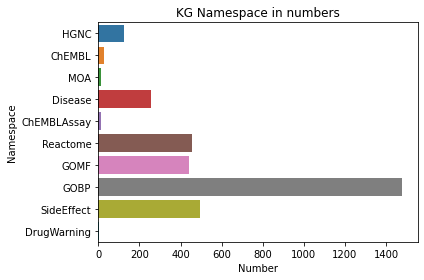

In [166]:
KG_namespace_plot(tnd,'tnd')

In [167]:
#to cytoscape compatible graphml 
pybel.to_graphml(tnd,'data/kgs/test/tnd.graphml')

#to regular BEL format
pybel.dump(tnd,'data/kgs/test/tnd.bel')

#to neo4j
pybel.to_csv(tnd,'data/kgs/test/tnd.csv')

#to sif
pybel.to_sif(tnd,'data/kgs/test/tnd.sif')

#to xml

#pybel.to

In [168]:
# filename = ('data/kgs/test/tnd.pkl')
# outfile = open(filename,'wb')
# pickle.dump(tnd,outfile)

In [7]:
infile = open('data/kgs/test/tnd.pkl','rb')
tnd = pickle.load(infile)
infile.close()

In [84]:
def filter_graph(mainGraph, vprotList):
    nsp_list = []
    chem_list = []
    for u, v, data in mainGraph.edges(data=True):
        if u.name in vprotList or v.name in vprotList:
            #print(u.name)
            nsp_list.append(u)
            #print(u)
            #print(v.name)
            nsp_list.append(v)

    nsp_graph = mainGraph.subgraph(nsp_list)
    #nsp_graph = pybel.struct.mutation.induction_expansion.get_subgraph_by_second_neighbors(mpox_graph, nsp_list, filter_pathologies=False)
    return(nsp_graph)


In [85]:
query = 'CHEMBL125 CHEMBL529 CHEMBL1631694'.split(' ')
#query = ['Virus Diseases','Smallpox']
#query = 'NS5B CYP3A4 IMPDH1'.split(' ')

In [33]:
query

['CHEMBL125', 'CHEMBL529', 'CHEMBL1631694']

In [255]:
query = chembl

In [86]:
query_graph = filter_graph(tnd,query)

In [87]:
to_jupyter(query_graph)

<IPython.core.display.Javascript object>

In [169]:
import py2neo

In [171]:
## to Neo4j
# Exporting graph to Neo4J
import py2neo
node_map = {}

# NEO4J_USER = 'yojana'
# NEO4J_PASS = 'abc'

#neo_connection = py2neo.Graph('bolt://localhost:7687', auth=('neo4j', 'itmp'),name='mpoxkg')
neo_connection = py2neo.Graph('bolt://localhost:7687', auth=('tndkg', 'tnd'),name = 'tnd')
neo_connection.delete_all()
tx = neo_connection.begin()

nodes = list(tnd)

dbio = nx.get_node_attributes(tnd,'3Dbio')
uprot = nx.get_node_attributes(tnd,'UniProt')
chembl = nx.get_node_attributes(tnd,'ChEMBL')
uprot_predicted = nx.get_node_attributes(tnd,'Type')

for node in tqdm(nodes, desc="nodes"):
    attrs = {"namespace": node.namespace}

    if node.name and node.identifier:
        attrs["name"] = node.name
        attrs["identifier"] = node.identifier
    elif node.identifier and not node.name:
        attrs["name"] = node.identifier
    elif node.name and not node.identifier:
        attrs["name"] = node.name
    
    if node in dbio:
        attrs['3Dbio'] = dbio[node]
        
    if node in uprot:
        attrs['UniProt'] = uprot[node]
        
    if node in chembl:
        attrs['ChEMBL'] = chembl[node]
        
    if node in uprot_predicted:
        attrs['Type'] = uprot_predicted[node]

    node_map[node] = py2neo.Node(node.function, **attrs)

    tx.create(node_map[node])

edges = tnd.edges(keys=True, data=True)

for u, v, key, node in tqdm(edges, desc="edges"):
    rel_type = node['relation']

    d = node.copy()
    del d['relation']

    attrs = {}

    annotations = d.pop('annotations', None)
    if annotations:
        for annotation, values in annotations.items():
            attrs[annotation] = list(values)

    citation = d.pop('citation', None)
    if citation:
        attrs['citation'] = citation.curie

    if 'evidence' in d:
        attrs['evidence'] = d['evidence']

    rel = py2neo.Relationship(node_map[u], rel_type, node_map[v], key=key, **attrs)
    tx.create(rel)
    
tx.commit()

nodes:   0%|          | 0/3309 [00:00<?, ?it/s]

edges:   0%|          | 0/10743 [00:00<?, ?it/s]

C:\Users\reagon.karki\AppData\Local\Temp\ipykernel_1564\1597607442.py:73: DeprecationWarning: The transaction.commit() method is deprecated, use graph.commit(transaction) instead
  tx.commit()
